# ML2 Coursework - Complete Pipeline

This notebook combines all stages of the coursework into one coherent end-to-end workflow:
1. Data loading and initial preparation
2. Dataset creation (A0 and A1)
3. Feature engineering
4. Data preprocessing
5. Model creation and training
6. Model evaluation
7. Results and conclusions


## 1. Introduction and Setup

### Libraries Import


In [105]:
# Core libraries
import pandas as pd
import numpy as np
import os
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, 
    precision_recall_curve, average_precision_score, roc_auc_score,
    mean_squared_error
)

%pip install xgboost
# XGBoost
from xgboost import XGBClassifier

# Statistical functions
import scipy.stats as st

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
np.seterr(all="ignore")


Note: you may need to restart the kernel to use updated packages.


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 2. Data Loading and Initial Preparation

Firstly, We combine all seasons for each country into Dataframes, then we combine all country Dataframes into 1. At this stage we keep all the variables in place and we are going to create A0 and A1 datasets later.

In [106]:
# Check if combined CSVs already exist, otherwise create them
# Try both possible directory names
root_dir = None
for possible_dir in ["raw_data", "data"]:
    if os.path.exists(possible_dir):
        root_dir = possible_dir
        break

if root_dir is None:
    raise FileNotFoundError("Neither 'raw_data' nor 'data' directory found. Please check your data directory.")

output_dir = "combined_csvs"
os.makedirs(output_dir, exist_ok=True)

# Check if combined CSVs exist
combined_files_exist = all(
    os.path.exists(os.path.join(output_dir, f"{country}.csv"))
    for country in ["belgium", "england", "france", "germany", "greece", 
                    "italy", "netherlands", "portugal", "scotland", "spain", "turkey"]
)

if not combined_files_exist:
    print("Combined CSVs not found. Creating them from raw data...")
    
    folder_dfs = {}  # Nested dict: country -> subfolder -> CSV -> DataFrame
    
    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if dirpath == root_dir:
            continue  # skip root
        
        # Split the path components relative to root_dir
        rel_path = os.path.relpath(dirpath, root_dir).split(os.sep)
        
        # Expecting: ["england", "0"] or ["england", "1"], etc.
        if len(rel_path) != 2:
            continue  # skip if not exactly two levels below root
        
        country, subfolder = rel_path
        
        # Initialize nested dicts
        folder_dfs.setdefault(country, {})
        folder_dfs[country].setdefault(subfolder, {})
        
        # Loop through CSV files
        for filename in filenames:
            if filename.endswith(".csv"):
                file_path = os.path.join(dirpath, filename)
                try:
                    df = pd.read_csv(file_path, low_memory=False)
                    csv_name = os.path.splitext(filename)[0]  # e.g. "1920"
                    folder_dfs[country][subfolder][csv_name] = df
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    
    def concat_country_data(country_name):
        """Concatenate all CSVs for a given country (across all subfolders)."""
        if country_name not in folder_dfs:
            return pd.DataFrame()
        # Flatten all subfolder DataFrames into one list
        dfs = []
        for subfolder in folder_dfs[country_name].values():
            dfs.extend(subfolder.values())
        # Combine them into one big DataFrame
        if dfs:
            return pd.concat(dfs, ignore_index=True)
        return pd.DataFrame()
    
    # Build DataFrames per country
    belgium_data = concat_country_data("belgium")
    england_data = concat_country_data("england")
    france_data = concat_country_data("france")
    germany_data = concat_country_data("germany")
    greece_data = concat_country_data("greece")
    italy_data = concat_country_data("italy")
    netherlands_data = concat_country_data("netherlands")
    portugal_data = concat_country_data("portugal")
    scotland_data = concat_country_data("scotland")
    spain_data = concat_country_data("spain")
    turkey_data = concat_country_data("turkey")
    
    country_dfs = {
        "belgium": belgium_data,
        "england": england_data,
        "france": france_data,
        "germany": germany_data,
        "greece": greece_data,
        "italy": italy_data,
        "netherlands": netherlands_data,
        "portugal": portugal_data,
        "scotland": scotland_data,
        "spain": spain_data,
        "turkey": turkey_data
    }

    # Save combined CSVs
    for country, df in country_dfs.items():
        if not df.empty:
            file_path = os.path.join(output_dir, f"{country}.csv")
            df.to_csv(file_path, index=False)
            print(f"Saved {file_path} (shape={df.shape})")
    
    print("\nCombined CSVs created successfully!")
else:
    print("Combined CSVs already exist. Loading from disk...")


Combined CSVs already exist. Loading from disk...


In [107]:
# Load combined country data
b_data = pd.read_csv(os.path.join(output_dir, 'belgium.csv'), low_memory=False)
eng_data = pd.read_csv(os.path.join(output_dir, 'england.csv'), low_memory=False)
fr_data = pd.read_csv(os.path.join(output_dir, 'france.csv'), low_memory=False)
d_data = pd.read_csv(os.path.join(output_dir, 'germany.csv'), low_memory=False)
gr_data = pd.read_csv(os.path.join(output_dir, 'greece.csv'), low_memory=False)
it_data = pd.read_csv(os.path.join(output_dir, 'italy.csv'), low_memory=False)
ne_data = pd.read_csv(os.path.join(output_dir, 'netherlands.csv'), low_memory=False)
por_data = pd.read_csv(os.path.join(output_dir, 'portugal.csv'), low_memory=False)
sc_data = pd.read_csv(os.path.join(output_dir, 'scotland.csv'), low_memory=False)
sp_data = pd.read_csv(os.path.join(output_dir, 'spain.csv'), low_memory=False)
tur_data = pd.read_csv(os.path.join(output_dir, 'turkey.csv'), low_memory=False)

# Combine all countries into one dataset
data_og = pd.DataFrame()
for df in [b_data, eng_data, fr_data, d_data, gr_data, it_data, ne_data, por_data, sc_data, sp_data, tur_data]:
    data_og = pd.concat([data_og, df], ignore_index=True)

print(f"Total dataset shape: {data_og.shape}")
print(f"Columns: {data_og.columns.tolist()[:10]}...")

# Duplicates Removal
data_og = data_og.drop_duplicates(subset=['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'])
print(f"Dataset shape after removing duplicates: {data_og.shape}")

Total dataset shape: (42593, 137)
Columns: ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG']...
Dataset shape after removing duplicates: (42593, 137)


In our case there's no duplicates, however it is an essential step in every project. 

## 3. Dataset Creation (A0 and A1)

We create two datasets:
- **A0**: Limited features (basic match information)
- **A1**: Extended features with betting odds and market aggregates


### 3.1 A0 Dataset Creation

A0 dataset uses only basic features: Div, Date, Time, HomeTeam, AwayTeam, FTHG, FTAG, FTR. At this stage the variables used is given, thus no explanation for their choice is needed. However, we split the "Div" variable into 2 using the Letters as a country name and the number as a division. We also create columns "Total_goals" from which we derive the binary target variable. Lastly in this part, we unify the datetime format and convert time format into simple integers.


In [108]:
col_list_a0 = ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']

def a0_data(df, feature_list):
    """Create A0 dataset with basic features only."""
    df = df[feature_list].copy()
    # Extract Country and Division from Div column
    df[['Country', 'Division']] = df['Div'].str.extract(r'([A-Za-z]+)(\d+)')
    df.drop(columns=['Div'], inplace=True)
    # Create target variable
    df['Total_goals'] = df['FTHG'] + df['FTAG']
    df['Target'] = (df['Total_goals'] > 2.5).astype(int)  # 1 if more than 2.5 goals, else 0
    # Convert Date and Time to proper formats
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour
    return df

# Create A0 dataset for all countries
data_og_a0 = a0_data(data_og, col_list_a0)
print(f"A0 dataset shape: {data_og_a0.shape}")
print(f"A0 columns: {data_og_a0.columns.tolist()}")
data_og_a0.head()


A0 dataset shape: (42593, 11)
A0 columns: ['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'Country', 'Division', 'Total_goals', 'Target']


,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Country,Division,Total_goals,Target
0,2019-07-26,19,Genk,Kortrijk,2,1,H,B,1,3,1
1,2019-07-27,17,Cercle Brugge,Standard,0,2,A,B,1,2,0
2,2019-07-27,19,St Truiden,Mouscron,0,1,A,B,1,1,0
3,2019-07-27,19,Waregem,Mechelen,0,2,A,B,1,2,0
4,2019-07-27,19,Waasland-Beveren,Club Brugge,1,3,A,B,1,4,1


### 3.2 A1 Dataset Creation

#### **Reasoning behind choosing variables for further work**  

**Performance metrics**

Although the dataset contains many match-level statistics, some variables cannot be used to derive meaningful and unbiased performance metrics.
For example, while we have total shots (HS, AS) and shots on target (HST, AST), we cannot accurately calculate shot conversion rates because the data does not separate open-play goals from penalty goals. Any conversion metric would therefore be distorted by the number of penalties awarded to each team.

We also exclude offside counts (HO, AO). Offsides are recorded without any information about their location relative to goal or the danger level of the attacking play. Without this context, raw offside numbers do not provide reliable insight into attacking effectiveness.

Disciplinary variables (HY, AY, HR, AR, HBP, ABP) are also omitted. Although detailed, they are likely to introduce noise rather than deliver useful information about team performance quality, since card counts depend heavily on referee style and match context and are not direct indicators of playing strength.

**Betting Odds Variables**

For the bookmaker-based features, we use market-average odds for both the Asian Handicap and Over/Under 2.5 markets. The Asian Handicap was selected because it reflects the expected imbalance between the teams, which may translate into higher scoring potential for the stronger side.

We rely on market averages rather than a single bookmaker to avoid importing the specific biases and modelling errors of any one operator. Using averages provides a more stable and representative estimate of the underlying probabilities, and reduces the risk of incorporating bookmaker-specific inaccuracies into our own model.


In [109]:
col_list_a1 = ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 
               'AvgAHH', 'AvgAHA', 'Avg>2.5', 'Avg<2.5']

def a1_data(df, feature_list):
    """Create A1 dataset with betting odds features."""
    # Check which columns are available
    available_cols = [col for col in feature_list if col in df.columns]
    df = df[available_cols].copy()
    
    # Extract Country and Division from Div column
    df[['Country', 'Division']] = df['Div'].str.extract(r'([A-Za-z]+)(\d+)')
    df.drop(columns=['Div'], inplace=True)
    
    # Create target variable
    df['Total_goals'] = df['FTHG'] + df['FTAG']
    df['Target'] = (df['Total_goals'] > 2.5).astype(int)  # 1 if more than 2.5 goals, else 0
    
    return df

# Create A1 dataset for all countries
data_big = pd.DataFrame()
for df in [b_data, eng_data, fr_data, d_data, gr_data, it_data, ne_data, por_data, sc_data, sp_data, tur_data]:
    data_big = pd.concat([data_big, df], ignore_index=True)

big_data_a1 = a1_data(data_big, col_list_a1)
print(f"A1 dataset shape: {big_data_a1.shape}")
print(f"A1 columns: {big_data_a1.columns.tolist()}")
big_data_a1.head()


A1 dataset shape: (42593, 15)
A1 columns: ['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'AvgAHH', 'AvgAHA', 'Avg>2.5', 'Avg<2.5', 'Country', 'Division', 'Total_goals', 'Target']


,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,AvgAHH,AvgAHA,Avg>2.5,Avg<2.5,Country,Division,Total_goals,Target
0,26/07/2019,19:30,Genk,Kortrijk,2,1,H,2.05,1.79,1.51,2.48,B,1,3,1
1,27/07/2019,17:00,Cercle Brugge,Standard,0,2,A,1.90,1.93,1.74,2.06,B,1,2,0
2,27/07/2019,19:00,St Truiden,Mouscron,0,1,A,1.95,1.88,1.82,1.98,B,1,1,0
3,27/07/2019,19:00,Waregem,Mechelen,0,2,A,1.92,1.91,1.65,2.19,B,1,2,0
4,27/07/2019,19:30,Waasland-Beveren,Club Brugge,1,3,A,1.96,1.87,1.55,2.38,B,1,4,1


## 4. Feature Engineering

We engineer features for both A0 and A1 datasets, including:
- Calendar features (Year, Month, Dayofweek, Is_weekend, Season_of_year)
- Team encoding (LabelEncoder)
- Rolling averages (last 5 matches)
- Betting market features (probabilities, normalization)

We're using LabelEncoder for teams which assigns arbitrary integers to team names. This is appropriate for tree-based models (Random Forest, XGBoost) which don't assume ordinality in numeric features, but less ideal for linear models like Logistic Regression. For linear models, One-Hot Encoding would be more appropriate, but would create too many columns given the number of teams. 

An alternative and more sophisticated approach are embeddings for teams, however this method wasn't utilized due to severely limited time we had for he project. 

---

### Feature engineering for A0

#### **Rolling values**

For every football match, we create rolling averages for goals scored and conceded in the last 5 matches.  
Since research shows home and away matches behave differently, we treat them separately:

- Home team averages use only the previous 5 *home* matches.
- Away team averages use only the previous 5 *away* matches.
- The same logic is used for goals conceded.

This prevents data leakage and respects team-specific home/away performance patterns.

#### **Time features**

Datetime is decomposed into:
- Month
- Year
- Day of the week
- Weekend flag (0 = weekday, 1 = weekend)

Most matches occur on weekends, so the effect may be small, but it still captures structural scheduling patterns.  
We also assign each date a **season** (summer, autumn, winter, spring).

#### **Countries and divisions**

Countries and divisions are encoded using dummy variables.  
This adds only a modest number of columns and enables league-specific structure to be learned.

Finally, we drop any variables unavailable at kickoff or variables that would leak the match outcome.

---

---

### Additional feature engineering for A1

The A1 model includes all A0 features plus betting-market-derived features.  
We use odds available before kickoff and convert them into normalized probabilities so the model works with comparable inputs.

We use **only the home-side variable** for both markets (O/U and Asian Handicap) to avoid multicollinearity.

---

#### **Over/Under odds**

**1. Raw implied probabilities**

$$
p_{\text{over, raw}} = \frac{1}{\text{Avg}>2.5}
$$

$$
p_{\text{under, raw}} = \frac{1}{\text{Avg}<2.5}
$$

**2. Normalize probabilities (remove overround)**

$$
p_{\text{over}} =
\frac{p_{\text{over, raw}}}
{p_{\text{over, raw}} + p_{\text{under, raw}}}
$$

$$
p_{\text{under}} = 1 - p_{\text{over}}
$$

**Key features kept**
- `P_over`
- `market_decisiveness = |P_over - 0.5|`

Note: Market decisiveness measures how strongly the betting market leans toward either over or under 2.5 goals.
Values close to 0 indicate an evenly balanced market, while values closer to 0.5 reflect a clear and confident market preference for one side.

**3. Market-implied expected goals**

$$
\text{expected\_total\_goals} =
2.5 +
\frac{\ln(P_{\text{over}} + \varepsilon)}
{1 - (P_{\text{over}} - 0.5) + \varepsilon}
$$

his formula has the following properties:
1. When P_over = 0.5 (market expects exactly 2.5 goals), the formula returns 2.5
2. As P_over increases (market expects more goals), the expected total increases
3. As P_over decreases (market expects fewer goals), the expected total decreases

The formula is derived from empirical analysis of historical odds and actual totals, not from a theoretical model. It provides a reasonable mapping from probabilities to expected goals that aligns with market expectations.

Where:

- $\varepsilon = 1 \times 10^{-9}$ -> this avoids dividing by 0
- Increasing $P_{over}$ increases expected total goals

---

#### **Asian handicap odds**

**1. Raw implied probabilities**

$$
p_{\text{AH, home}} = \frac{1}{\text{AvgAHH}}
$$

$$
p_{\text{AH, away}} = \frac{1}{\text{AvgAHA}}
$$

**2. Normalize probabilities**

$$
\text{Norm\_Ah\_P\_home} =
\frac{p_{\text{AH, home}}}
{p_{\text{AH, home}} + p_{\text{AH, away}}}
$$

$$
\text{Norm\_Ah\_P\_away} =
1 - \text{Norm\_Ah\_P\_home}
$$

---

**3. Additional AH features**

**Market imbalance**

Measures how different the implied probabilities are between home and away AH odds.  
Large differences mean the market strongly favors one side.

$$
\text{ah\_imbalance} =
\left| p_{\text{AH, home}} - p_{\text{AH, away}} \right|
$$

**Market confidence**

Captures how strongly the market believes in its preferred side, regardless of direction.  
It simply takes the higher implied probability.

$$
\text{ah\_market\_confidence} =
\max(p_{\text{AH, home}},\; p_{\text{AH, away}})
$$

---

#### **Summary of A1 betting-derived features**

From Over/Under market
- `P_over`
- `market_decisiveness`
- `expected_total_goals`

From Asian Handicap market
- `Norm_Ah_P_home`
- `ah_imbalance`
- `ah_market_confidence`


In [110]:
def get_season(date):
    """Get season of year: 0=winter, 1=spring, 2=summer, 3=autumn"""
    month = date.month
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3


In [111]:
def transf_encode_a0(df):
    """Transform and encode A0 dataset features."""
    # Sort by date to ensure chronological order for rolling averages
    df = df.sort_values('Date').copy()
    
    # Team encoding - use same encoder for both HomeTeam and AwayTeam
    team_encoder = LabelEncoder()
    all_teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()
    team_encoder.fit(all_teams)
    
    # Home team features
    df['HomeTeam_enc'] = team_encoder.transform(df['HomeTeam'])
    df = df.sort_values(["HomeTeam_enc", "Date"])
    df['avg_goals_in_last5_home'] = (
        df.groupby("HomeTeam_enc")["FTHG"]
        .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
    )
    df['avg_goals_conceded_last5_home'] = (
        df.groupby("HomeTeam_enc")["FTAG"]
        .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
    )
    
    # Away team features
    df['AwayTeam_enc'] = team_encoder.transform(df['AwayTeam'])
    df = df.sort_values(["AwayTeam_enc", "Date"])
    df['avg_goals_in_last5_away'] = (
        df.groupby("AwayTeam_enc")["FTAG"]
        .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
    )
    df['avg_goals_conceded_last5_away'] = (
        df.groupby("AwayTeam_enc")["FTHG"]
        .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
    )
    
    # Sort back to chronological order
    df = df.sort_values('Date')
    
    # Calendar-based features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Dayofweek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
    df['Is_weekend'] = df['Dayofweek'].isin([5, 6]).astype(int)
    df['Season_of_year'] = df['Date'].apply(get_season)
    
    # Encode Country and Division as dummies
    if 'Country' in df.columns:
        df = pd.get_dummies(df, columns=['Country', 'Division'], drop_first=True)
        bool_cols = df.select_dtypes(include='bool').columns
        if len(bool_cols) > 0:
            df[bool_cols] = df[bool_cols].astype(int)
    else:
        df = pd.get_dummies(df, columns=['Division'], drop_first=True)
        if 'Country' in df.columns:
            df = df.drop(columns=['Country'])
    
    # Drop columns used in calculations
    df = df.drop(columns=['Total_goals', 'FTHG', 'FTAG', 'FTR', 'HomeTeam', 'AwayTeam', 'Date'])
    
    return df


In [112]:
def transf_encode_a1(df):
    """Transform and encode A1 dataset features with betting odds."""
    # Sort by date
    df = df.sort_values('Date').copy()
    
    # Convert Date and Time if not already converted
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    if not isinstance(df['Time'].iloc[0], (int, np.integer)):
        df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour
    
    # Team encoding
    team_encoder = LabelEncoder()
    all_teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()
    team_encoder.fit(all_teams)
    
    # Home team features
    df['HomeTeam_enc'] = team_encoder.transform(df['HomeTeam'])
    df = df.sort_values(["HomeTeam_enc", "Date"])
    df['avg_goals_in_last5_home'] = (
        df.groupby("HomeTeam_enc")["FTHG"]
        .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
    )
    df['avg_goals_conceded_last5_home'] = (
        df.groupby("HomeTeam_enc")["FTAG"]
        .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
    )
    
    # Away team features
    df['AwayTeam_enc'] = team_encoder.transform(df['AwayTeam'])
    df = df.sort_values(["AwayTeam_enc", "Date"])
    df['avg_goals_in_last5_away'] = (
        df.groupby("AwayTeam_enc")["FTAG"]
        .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
    )
    df['avg_goals_conceded_last5_away'] = (
        df.groupby("AwayTeam_enc")["FTHG"]
        .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
    )
    
    # Sort back to chronological order
    df = df.sort_values('Date')
    
    # Over/Under market features
    if 'Avg>2.5' in df.columns and 'Avg<2.5' in df.columns:
        # Convert odds to probabilities
        df["p_over_raw"] = 1 / df["Avg>2.5"]
        df["p_under_raw"] = 1 / df["Avg<2.5"]
        # Normalize to remove overround
        df["p_over_norm"] = df["p_over_raw"] / (df["p_over_raw"] + df["p_under_raw"])
        df["p_under_norm"] = 1 - df["p_over_norm"]
        
        # Key modeling features
        df["P_over"] = df["p_over_norm"]
        df["market_decisiveness"] = (df["P_over"] - 0.5).abs()
        # Expected total goals based on market probability
        df["expected_total_goals"] = 2.5 + np.log(df['P_over'] + 1e-9) / (1 - (df["P_over"] - 0.5) + 1e-9)
    
    # Asian Handicap features
    if 'AvgAHH' in df.columns and 'AvgAHA' in df.columns:
        # Filter out invalid odds (must be > 1.0)
        df = df[df['AvgAHH'] > 1.0].copy()
        df = df[df['AvgAHA'] > 1.0].copy()
        
        # Convert odds to probabilities
        df['Ah_P_home'] = 1 / df['AvgAHH']
        df['Ah_P_away'] = 1 / df['AvgAHA']
        
        # Normalized probabilities
        df['Norm_Ah_P_home'] = df['Ah_P_home'] / (df['Ah_P_home'] + df['Ah_P_away'])
        df['Norm_Ah_P_away'] = 1 - df['Norm_Ah_P_home']
        
        # Market imbalance and confidence
        df['ah_imbalance'] = (df['Ah_P_home'] - df['Ah_P_away']).abs()
        df['ah_market_confidence'] = df[['Ah_P_home', 'Ah_P_away']].max(axis=1)
    
    # Calendar-based features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Dayofweek'] = df['Date'].dt.dayofweek
    df['Is_weekend'] = df['Dayofweek'].isin([5, 6]).astype(int)
    df['Season_of_year'] = df['Date'].apply(get_season)
    
    # Encode Country and Division as dummies
    if 'Country' in df.columns:
        df = pd.get_dummies(df, columns=['Country', 'Division'], drop_first=True)
        bool_cols = df.select_dtypes(include='bool').columns
        if len(bool_cols) > 0:
            df[bool_cols] = df[bool_cols].astype(int)
    else:
        df = pd.get_dummies(df, columns=['Division'], drop_first=True)
        if 'Country' in df.columns:
            df = df.drop(columns=['Country'])
    
    # Drop unneeded columns
    cols_to_drop = [
        'Total_goals', 'FTHG', 'FTAG', 'FTR', 'HomeTeam', 'AwayTeam', 'Date',
        'p_over_raw', 'p_under_raw', 'p_over_norm', 'p_under_norm',
        'over_price', 'P_over',
        'Ah_P_home', 'Ah_P_away',
        'Avg>2.5', 'Avg<2.5', 'AvgAHH', 'AvgAHA'
    ]
    # Only drop columns that exist
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    df = df.drop(columns=cols_to_drop)
    
    return df


In [113]:
# Apply feature engineering to A0 dataset
data_og_a0_encoded = transf_encode_a0(data_og_a0.copy())
print(f"A0 encoded shape: {data_og_a0_encoded.shape}")
print(f"A0 encoded columns: {data_og_a0_encoded.columns.tolist()}")
data_og_a0_encoded.head()


A0 encoded shape: (42593, 26)
A0 encoded columns: ['Time', 'Target', 'HomeTeam_enc', 'avg_goals_in_last5_home', 'avg_goals_conceded_last5_home', 'AwayTeam_enc', 'avg_goals_in_last5_away', 'avg_goals_conceded_last5_away', 'Year', 'Month', 'Dayofweek', 'Is_weekend', 'Season_of_year', 'Country_D', 'Country_E', 'Country_F', 'Country_G', 'Country_I', 'Country_N', 'Country_P', 'Country_SC', 'Country_SP', 'Country_T', 'Division_1', 'Division_2', 'Division_3']


,Time,Target,HomeTeam_enc,avg_goals_in_last5_home,avg_goals_conceded_last5_home,AwayTeam_enc,avg_goals_in_last5_away,avg_goals_conceded_last5_away,Year,Month,...,Country_G,Country_I,Country_N,Country_P,Country_SC,Country_SP,Country_T,Division_1,Division_2,Division_3
19697,19,1,420,NaN,NaN,204,NaN,NaN,2019,7,...,0,0,0,0,0,0,0,0,1,0
15758,19,0,101,NaN,NaN,444,NaN,NaN,2019,7,...,0,0,0,0,0,0,0,0,1,0
15757,19,1,8,NaN,NaN,245,NaN,NaN,2019,7,...,0,0,0,0,0,0,0,0,1,0
15760,19,1,201,NaN,NaN,196,NaN,NaN,2019,7,...,0,0,0,0,0,0,0,0,1,0
15763,19,0,372,NaN,NaN,44,NaN,NaN,2019,7,...,0,0,0,0,0,0,0,0,1,0


In [114]:
# Apply feature engineering to A1 dataset
data_big_a1_encoded = transf_encode_a1(big_data_a1.copy())
print(f"A1 encoded shape: {data_big_a1_encoded.shape}")
print(f"A1 encoded columns: {data_big_a1_encoded.columns.tolist()}")
data_big_a1_encoded.head()


A1 encoded shape: (42545, 32)
A1 encoded columns: ['Time', 'Target', 'HomeTeam_enc', 'avg_goals_in_last5_home', 'avg_goals_conceded_last5_home', 'AwayTeam_enc', 'avg_goals_in_last5_away', 'avg_goals_conceded_last5_away', 'market_decisiveness', 'expected_total_goals', 'Norm_Ah_P_home', 'Norm_Ah_P_away', 'ah_imbalance', 'ah_market_confidence', 'Year', 'Month', 'Dayofweek', 'Is_weekend', 'Season_of_year', 'Country_D', 'Country_E', 'Country_F', 'Country_G', 'Country_I', 'Country_N', 'Country_P', 'Country_SC', 'Country_SP', 'Country_T', 'Division_1', 'Division_2', 'Division_3']


,Time,Target,HomeTeam_enc,avg_goals_in_last5_home,avg_goals_conceded_last5_home,AwayTeam_enc,avg_goals_in_last5_away,avg_goals_conceded_last5_away,market_decisiveness,expected_total_goals,...,Country_G,Country_I,Country_N,Country_P,Country_SC,Country_SP,Country_T,Division_1,Division_2,Division_3
19697,19,1,420,NaN,NaN,204,NaN,NaN,0.066234,1.890909,...,0,0,0,0,0,0,0,0,1,0
15758,19,0,101,NaN,NaN,444,NaN,NaN,0.056136,1.730935,...,0,0,0,0,0,0,0,0,1,0
15757,19,1,8,NaN,NaN,245,NaN,NaN,0.144769,1.595899,...,0,0,0,0,0,0,0,0,1,0
15760,19,1,201,NaN,NaN,196,NaN,NaN,0.070312,1.710794,...,0,0,0,0,0,0,0,0,1,0
15763,19,0,372,NaN,NaN,44,NaN,NaN,0.114610,1.644545,...,0,0,0,0,0,0,0,0,1,0


## 5. Data Preprocessing

Before model training, we need to:
- Fix data types (boolean dummies to int)
- Remove infinity values
- Handle missing values
- Sort chronologically
- Split into train/test sets


In [115]:
# Fix boolean dummies to int
for df in [data_og_a0_encoded, data_big_a1_encoded]:
    bool_cols = df.select_dtypes(include='bool').columns
    if len(bool_cols) > 0:
        df[bool_cols] = df[bool_cols].astype(int)

# Replace infinity values with NaN
for df in [data_og_a0_encoded, data_big_a1_encoded]:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Note: Data should already be sorted chronologically from feature engineering step
# Reset index to ensure clean indexing
for df in [data_og_a0_encoded, data_big_a1_encoded]:
    df.reset_index(drop=True, inplace=True)

print("Data preprocessing complete.")
print(f"A0 shape: {data_og_a0_encoded.shape}")
print(f"A1 shape: {data_big_a1_encoded.shape}")

# Check for non-numeric columns
non_numeric_a0 = data_og_a0_encoded.select_dtypes(exclude=[np.number]).columns
non_numeric_a1 = data_big_a1_encoded.select_dtypes(exclude=[np.number]).columns
print(f"\nNon-numeric columns in A0: {list(non_numeric_a0)}")
print(f"Non-numeric columns in A1: {list(non_numeric_a1)}")


Data preprocessing complete.
A0 shape: (42593, 26)
A1 shape: (42545, 32)

Non-numeric columns in A0: []
Non-numeric columns in A1: []


As betting data tends to be noisy and such outliers are present in our dataset, they were artificially "clipped" - changed to the lower/upper bound.

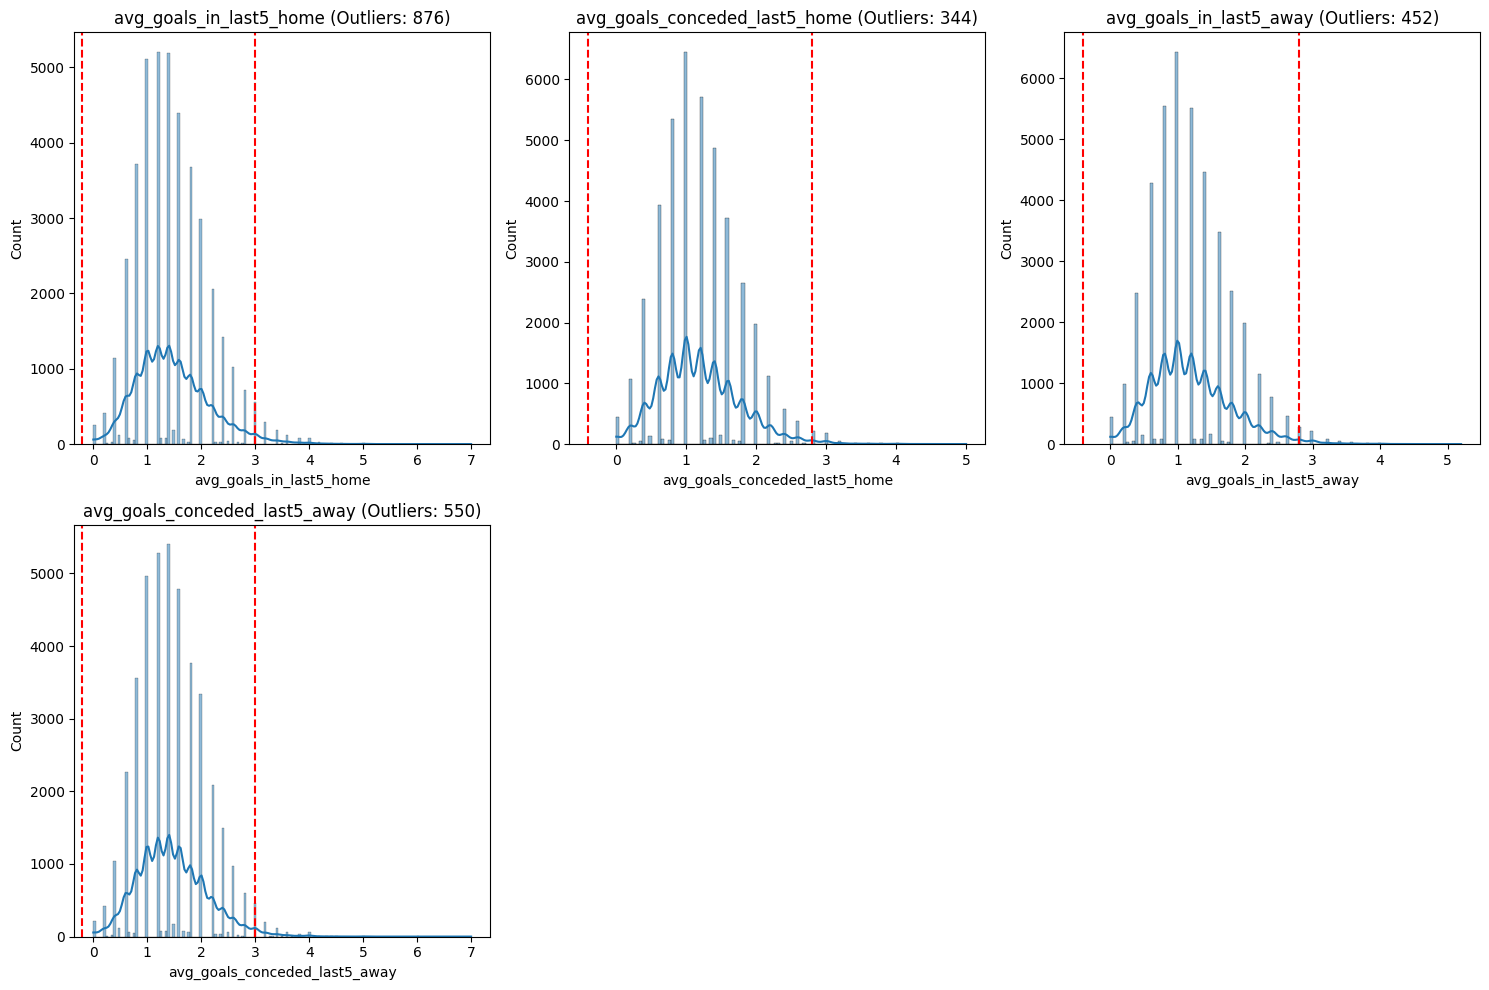

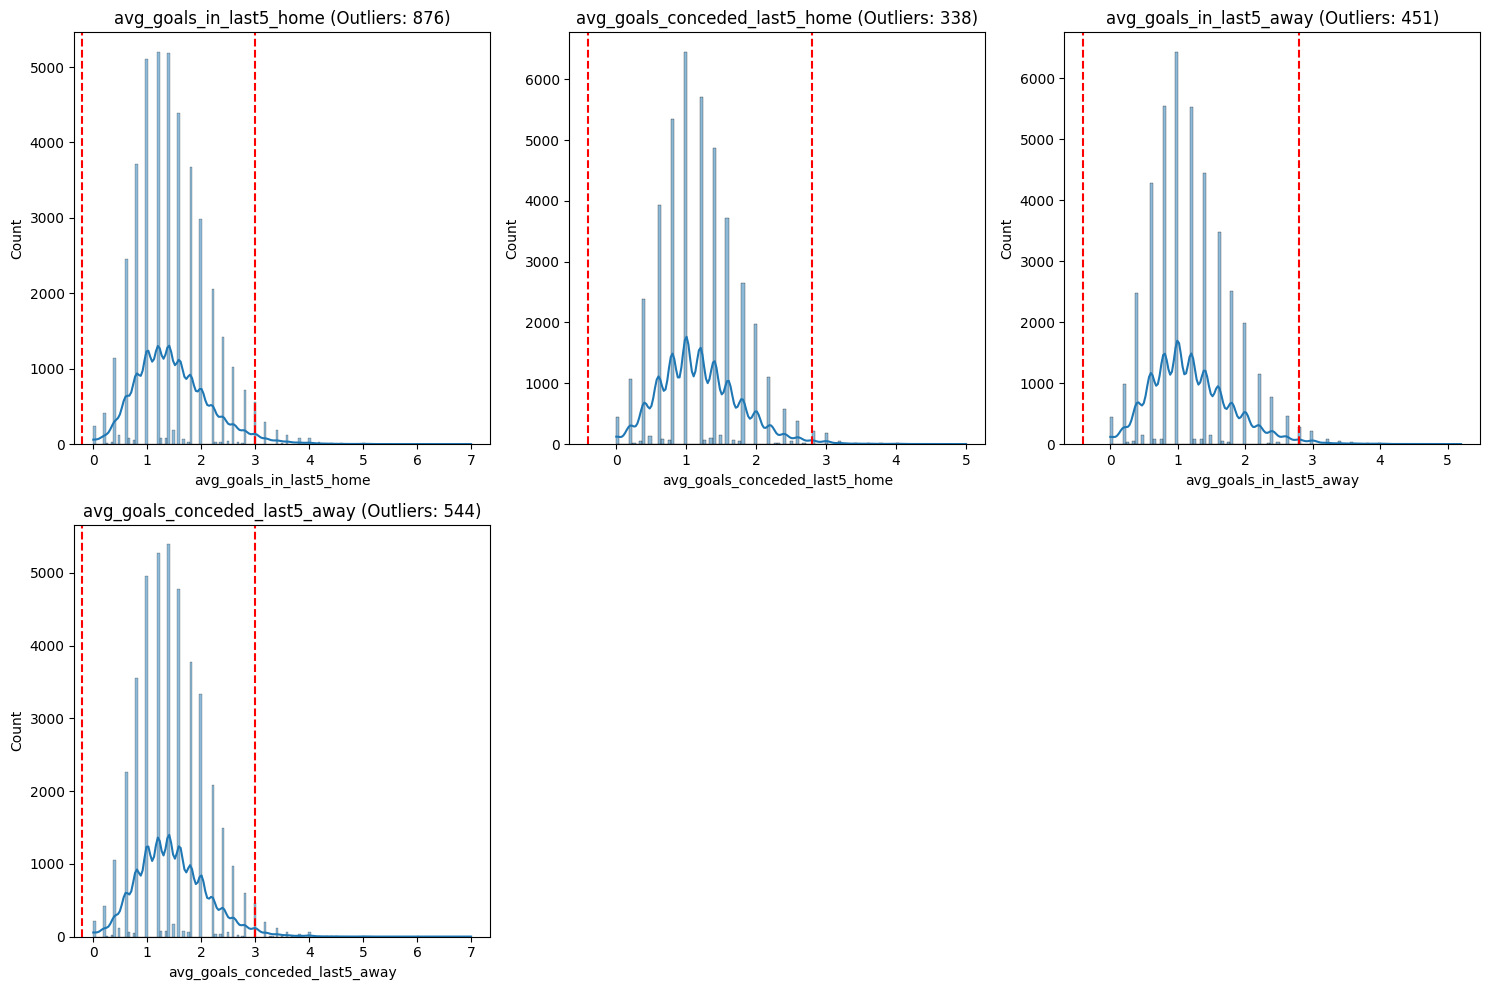

In [127]:
def detect_outliers(df, cols):
    """Detect outliers using IQR method and visualize distributions."""
    outliers = {}
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(cols):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outliers[col] = outlier_mask.sum()
        
        # Plot distribution
        plt.subplot(len(cols)//3 + 1, 3, i+1)
        sns.histplot(df[col], kde=True)
        plt.axvline(lower_bound, color='r', linestyle='--')
        plt.axvline(upper_bound, color='r', linestyle='--')
        plt.title(f"{col} (Outliers: {outlier_mask.sum()})")
    
    plt.tight_layout()
    plt.show()
    return outliers

# Check for outliers in key features
numeric_cols = ['avg_goals_in_last5_home', 'avg_goals_conceded_last5_home', 
                'avg_goals_in_last5_away', 'avg_goals_conceded_last5_away']

detect_outliers(data_og_a0_encoded, numeric_cols)
detect_outliers(data_big_a1_encoded, numeric_cols)

def clip_outliers(df, cols):
    """Clip extreme values to reasonable bounds."""
    df_copy = df.copy()
    for col in cols:
        Q1 = df_copy[col].quantile(0.05)  # 5th percentile
        Q3 = df_copy[col].quantile(0.95)  # 95th percentile
        IQR = Q3 - Q1
        lower_bound = Q1 - 2.0 * IQR
        upper_bound = Q3 + 2.0 * IQR
        df_copy[col] = df_copy[col].clip(lower_bound, upper_bound)
    return df_copy

data_og_a0_encoded = clip_outliers(data_og_a0_encoded, numeric_cols)
data_big_a1_encoded = clip_outliers(data_big_a1_encoded, numeric_cols)

In [116]:
# Chronological train/test split (80/20)
# Since data is already sorted chronologically from feature engineering, we split by index

def chrono_split(df, test_frac=0.2):
    """Split dataframe chronologically (assumes data is already sorted by date)."""
    df = df.reset_index(drop=True)
    cut = int(np.floor((1 - test_frac) * len(df)))
    return df.iloc[:cut].copy(), df.iloc[cut:].copy()

# Split A0 dataset
train0, test0 = chrono_split(data_og_a0_encoded)
X_train_0 = train0.drop(columns='Target')
y_train_0 = train0['Target'].astype(int)
X_test_0 = test0.drop(columns='Target')
y_test_0 = test0['Target'].astype(int)

# Split A1 dataset
train1, test1 = chrono_split(data_big_a1_encoded)
X_train_1 = train1.drop(columns='Target')
y_train_1 = train1['Target'].astype(int)
X_test_1 = test1.drop(columns='Target')
y_test_1 = test1['Target'].astype(int)

print(f"A0 - Train: {X_train_0.shape}, Test: {X_test_0.shape}")
print(f"A1 - Train: {X_train_1.shape}, Test: {X_test_1.shape}")


A0 - Train: (34074, 25), Test: (8519, 25)
A1 - Train: (34036, 31), Test: (8509, 31)


In [ ]:
# Build preprocessing pipeline
def build_preprocessor(X, for_linear=False, use_knn=True):
    """Build preprocessing pipeline focusing only on numeric columns."""
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    # All categorical columns should already be encoded as dummies by this point
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    if cat_cols:
        print(f"WARNING: Unexpected categorical columns found: {cat_cols}")
    
    # Numeric pipeline
    num_steps = [("impute_num", KNNImputer(n_neighbors=5) if use_knn else SimpleImputer(strategy="median"))]
    if for_linear:
        num_steps.append(("scale", StandardScaler()))
    
    num_pipe = Pipeline(num_steps)
    
    # Only include categorical pipeline if needed (Clearly wont be needed in our particular project, however is here for future consistency of the code)
    if cat_cols:
        cat_pipe = Pipeline([
            ("impute_cat", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ])
        preprocessor = ColumnTransformer(
            [("num", num_pipe, num_cols),
             ("cat", cat_pipe, cat_cols)],
            remainder="drop",
            sparse_threshold=0.3
        )
    else:
        # Just use numeric pipeline
        preprocessor = ColumnTransformer(
            [("num", num_pipe, num_cols)],
            remainder="drop",
            sparse_threshold=0.3
        )
    
    return preprocessor

# Create preprocessors for A0 and A1
pre0 = build_preprocessor(X_train_0, for_linear=False, use_knn=True)
pre1 = build_preprocessor(X_train_1, for_linear=False, use_knn=True)

# Fit preprocessors and transform data
X_train_0_processed = pre0.fit_transform(X_train_0)
X_test_0_processed = pre0.transform(X_test_0)
X_train_1_processed = pre1.fit_transform(X_train_1)
X_test_1_processed = pre1.transform(X_test_1)

print("Preprocessing complete.")
print(f"A0 processed - Train: {X_train_0_processed.shape}, Test: {X_test_0_processed.shape}")
print(f"A1 processed - Train: {X_train_1_processed.shape}, Test: {X_test_1_processed.shape}")


Preprocessing complete.
A0 processed - Train: (34074, 25), Test: (8519, 25)
A1 processed - Train: (34036, 31), Test: (8509, 31)


### Data Leakage Prevention Details

We've implemented several safeguards against data leakage:

1. Chronological Ordering: All data is strictly sorted by date before any feature engineering or train/test splitting.

2. Shifted Rolling Features: We use .shift() before calculating rolling averages to ensure only past data influences each prediction.

3. Time Series Cross-Validation: Our model tuning uses TimeSeriesSplit which respects chronological order, unlike standard K-fold cross-validation.

4. Feature Selection: We carefully exclude any information not available at prediction time (e.g., second-half statistics when predicting pre-match).

In [131]:
# Final check for class imbalance
for dataset_name, y in [("A0 train", y_train_0), ("A0 test", y_test_0), 
                        ("A1 train", y_train_1), ("A1 test", y_test_1)]:
    class_counts = y.value_counts()
    class_balance = class_counts / len(y)
    print(f"{dataset_name} class balance: {class_balance.to_dict()}")

A0 train class balance: {0: 0.5043728355931208, 1: 0.49562716440687915}
A0 test class balance: {1: 0.5169620847517314, 0: 0.48303791524826856}
A1 train class balance: {0: 0.5048478082030791, 1: 0.4951521917969209}
A1 test class balance: {1: 0.5170995416617699, 0: 0.4829004583382301}


## 6. Model Creation and Training

We train three types of models for both A0 and A1 datasets:
- Random Forest Classifier
- XGBoost Classifier
- Logistic Regression

We use TimeSeriesSplit for a rolling cross-validation to prevent data leakage.


First, a function for tuning model hyperparameters is created. This fuction consists of a combination of RandomizedSearchCV and GridSearchCV. The random search is run 4 times to find some potentially good values, then an exhaustive grid search is performed to look for the best combination. The function takes an untuned model, an empty parameter grid, a grid of potential parameters, and the training data as inputs.   
This method is quite time consuming and may not find the optimal parameters, because the random search tries random values and may not come across the best ones. A more soptisticated method, and possibly faster one, would be using the optuna library. Such a step may improve the performance of the model.

In [118]:
#because the data is chronological, we cannot do a randomized cross-validation when choosing the model
#we will use a rolling cross-validation instead
tscv = TimeSeriesSplit(n_splits=5)
#this will split out data into 5 folds and we will always evaluate only based on the past, preventing leakage

def tune_hyperparameters(params, parameter_grid, model, x_train, y_train):
    #params is an empty grid to use in GridSearchCV later
    #parameter_grid is a filled out grid with ranges that is used for initial random search
    for state in [1, 20, 42, 200]:
    #the loop numbers were randomly chosen, they are just here as random seeds to make the results reproducible
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=parameter_grid,
            cv=tscv,
            n_iter=100,
            random_state=state,
            scoring="roc_auc",
            n_jobs=-1
        )
        random_search.fit(x_train, y_train)
        new_params=random_search.best_params_
        for key, value in new_params.items():
            params[key].append(value)
    #keeping only unique values in the parameter grid
    for key in params:
        params[key] = list(set(params[key]))

    #gridsearch with narrowed parameter grid from random search
    grid=GridSearchCV(estimator=model,
                      param_grid=params,
                      n_jobs=-1,
                      scoring="roc_auc",
                      cv=tscv)
    grid.fit(x_train, y_train)

    best_params=grid.best_params_
    best_model=grid.best_estimator_

    return best_params, best_model

A check is run before the models are implemented in order to avoid errors.

In [119]:
#assert that the data is usable for the models (no NaNs or infinite values)
assert np.isfinite(X_train_0_processed).all(), "there are NaNs or infinite numbers in X_train_0"
assert np.isfinite(y_train_0.to_numpy()).all(), "there are NaNs or infinite numbers in y_train_0"

assert np.isfinite(X_train_1_processed).all(), "there are NaNs or infinite numbers in X_train_1"
assert np.isfinite(y_train_1.to_numpy()).all(), "there are NaNs or infinite numbers in y_train_1"

In [120]:
#random forest
#initiate the model
rf = RandomForestClassifier(random_state=42)

#parameter grids for tuning
param_grid_rf= {
    'max_depth':[i for i in range(1, 30)],
    'min_samples_split':[i for i in range(1,300)],
    'min_samples_leaf':[i for i in range(1, 200)],
    'criterion' :['gini', 'entropy', 'log_loss']
}
params_rf={
    'max_depth':[],
    'min_samples_split':[],
    'min_samples_leaf':[],
    'criterion' :[]
}

In [121]:
#XGBoost
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
param_grid_xgb= {
    'n_estimators': st.randint(2, 300),
    'max_depth': st.randint(3, 8),
    'learning_rate': st.uniform(0.01, 0.25),
    'subsample': st.uniform(0.8, 0.2),
    'colsample_bytree': st.uniform(0.8, 0.2)
} #hyperparameters for xgboost, some are from a uniform distribution because they are floats and not integers
params_xgb={
    'n_estimators': [],
    'max_depth': [],
    'learning_rate': [],
    'subsample': [],
    'colsample_bytree': []
} #empty parameter grid to input the results of the random search

### 6.1 A0 Models

#### Random Forest Classifier (A0)


Because this is a classification task and we aren't looking at a continuous target variable, we will use the RandomForestClassifier and not the RandomForestRegressor we have used in the lectures.

In [122]:


#tune random forest for A0
best_params_rf0, rf_0=tune_hyperparameters(params=params_rf,
                                           parameter_grid=param_grid_rf,
                                           model=rf,
                                           x_train=X_train_0_processed,
                                           y_train=y_train_0)

pred_rf_a0 = rf_0.predict(X_test_0_processed)
print(f'Best hyperparameters: {best_params_rf0}')
print("Random Forest A0 trained successfully.")

KeyboardInterrupt: 

#### XGBoost Classifier (A0)


This process is mostly analogous to the random forest, only using a different classifier and different hyperparameters (since we need different things for the two). Otherwise, the model creation has the same steps and uses the time series cross validation that has already been used before.

In [ ]:
#tune XGBoost for A0
best_params_xgb0, xgb_0=tune_hyperparameters(params=params_xgb,
                                           parameter_grid=param_grid_xgb,
                                           model=xgb,
                                           x_train=X_train_0_processed,
                                           y_train=y_train_0)

pred_xgb_a0 = xgb_0.predict(X_test_0_processed)

print(f'Best hyperparameters: {best_params_xgb0}')
print("XGBoost A0 trained successfully.")

XGBoost A0 trained successfully.


#### Logistic Regression (A0)


Because we are predicting a binary outcome, we can use a logistic regression model, as it uses the probability of the outcome. This can be used as a sort of a baseline model to the more complicated ones.

In [ ]:


#logistic regression with time series Cross Validation (baseline)
logreg_0=LogisticRegressionCV(max_iter=10000, cv=tscv)

logreg_0.fit(X_train_0_processed, y_train_0)

pred_logreg_a0 = logreg_0.predict(X_test_0_processed)
print("Logistic Regression A0 trained successfully.")



Logistic Regression A0 trained successfully.


### 6.2 A1 Models

The models for A1 dataset are implemented and tuned in the same way as the A0 models.

#### Random Forest Classifier (A1)


In [ ]:


#tune random forest for A1
best_params_rf1, rf_1=tune_hyperparameters(params=params_rf,
                                           parameter_grid=param_grid_rf,
                                           model=rf,
                                           x_train=X_train_1_processed,
                                           y_train=y_train_1)
pred_rf_a1 = rf_1.predict(X_test_1_processed)

print(f'Best hyperparameters: {best_params_rf1}')
print("Random Forest A1 trained successfully.")



Random Forest A1 trained successfully.


#### XGBoost Classifier (A1)


In [ ]:
#tune random forest for A1
best_params_xgb1, xgb_1=tune_hyperparameters(params=params_xgb,
                                           parameter_grid=param_grid_xgb,
                                           model=xgb,
                                           x_train=X_train_1_processed,
                                           y_train=y_train_1)
pred_xgb_a1 = xgb_1.predict(X_test_1_processed)

print(f'Best hyperparameters: {best_params_xgb1}')
print("XGBoost A1 trained successfully.")

XGBoost A1 trained successfully.


#### Logistic Regression (A1)


In [ ]:
#logistic regression with time series Cross Validation (baseline)
logreg_1=LogisticRegressionCV(max_iter=10000, cv=tscv)

logreg_1.fit(X_train_1_processed, y_train_1)
pred_logreg_a1 = logreg_1.predict(X_test_1_processed)

print("Logistic Regression A1 trained successfully.")

Logistic Regression A1 trained successfully.


## 7. Model Evaluation

We evaluate all models using multiple metrics:
- Accuracy (with 95% confidence intervals)
- F1-score
- Precision-Recall (Average Precision)
- ROC-AUC
- Confusion matrices
- Threshold optimization


In [ ]:
def best_thr_by_f1(y_true, prob):
    """Find best threshold by maximizing F1 score."""
    p, r, t = precision_recall_curve(y_true, prob)
    f1 = 2 * p * r / (p + r + 1e-9)
    i = np.nanargmax(f1)
    return float(t[i]) if i < len(t) else 0.5

def acc_ci(y_true, y_pred, B=1000, seed=0):
    """Calculate 95% confidence interval for accuracy using bootstrap."""
    rng = np.random.default_rng(seed)
    n = len(y_true)
    vals = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        vals.append(accuracy_score(y_true[idx], y_pred[idx]))
    return tuple(np.percentile(vals, [2.5, 97.5]))

def fit_and_eval(model, Xtr, ytr, Xte, yte, label):
    """Train model and evaluate with threshold optimization."""
    # Get probabilities
    pr_tr = model.predict_proba(Xtr)[:, 1]
    thr = best_thr_by_f1(ytr.values, pr_tr)
    
    pr_te = model.predict_proba(Xte)[:, 1]
    pred = (pr_te >= thr).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(yte, pred)
    f1 = f1_score(yte, pred)
    ap = average_precision_score(yte, pr_te)
    auc = roc_auc_score(yte, pr_te)
    cm = confusion_matrix(yte, pred, labels=[0, 1])
    lo, hi = acc_ci(yte.values, pred)
    
    print(f"{label}: thr={thr:.3f} | ACC={acc:.4f} (95% [{lo:.4f},{hi:.4f}]) | "
          f"F1={f1:.4f} | AP={ap:.4f} | AUC={auc:.4f}")
    print("Confusion matrix [TN FP; FN TP]:")
    print(cm, "\n")
    
    return {
        'label': label, 'thr': thr, 'acc': acc, 'f1': f1, 
        'ap': ap, 'auc': auc, 'cm': cm, 'pred': pred, 'proba': pr_te
    }


In [ ]:
# Evaluate A0 models
print("=== A0 Models ===")
res_rf_a0 = fit_and_eval(rf_a0, X_train_0_processed, y_train_0, X_test_0_processed, y_test_0, "RF A0")
res_xgb_a0 = fit_and_eval(xgb_a0, X_train_0_processed, y_train_0, X_test_0_processed, y_test_0, "XGB A0")
res_logreg_a0 = fit_and_eval(logreg_a0, X_train_0_processed, y_train_0, X_test_0_processed, y_test_0, "LogReg A0")


=== A0 Models ===
RF A0: thr=0.436 | ACC=0.5212 (95% [0.5111,0.5320]) | F1=0.6658 | AP=0.5746 | AUC=0.5571
Confusion matrix [TN FP; FN TP]:
[[ 377 3738]
 [ 341 4063]] 

XGB A0: thr=0.406 | ACC=0.5194 (95% [0.5097,0.5303]) | F1=0.6742 | AP=0.5743 | AUC=0.5580
Confusion matrix [TN FP; FN TP]:
[[ 189 3926]
 [ 168 4236]] 

LogReg A0: thr=0.367 | ACC=0.5165 (95% [0.5066,0.5275]) | F1=0.6800 | AP=0.5700 | AUC=0.5537
Confusion matrix [TN FP; FN TP]:
[[  23 4092]
 [  27 4377]] 



In [ ]:
# Evaluate A1 models
print("=== A1 Models ===")
res_rf_a1 = fit_and_eval(rf_a1, X_train_1_processed, y_train_1, X_test_1_processed, y_test_1, "RF A1")
res_xgb_a1 = fit_and_eval(xgb_a1, X_train_1_processed, y_train_1, X_test_1_processed, y_test_1, "XGB A1")
res_logreg_a1 = fit_and_eval(logreg_a1, X_train_1_processed, y_train_1, X_test_1_processed, y_test_1, "LogReg A1")


=== A1 Models ===
RF A1: thr=0.396 | ACC=0.5306 (95% [0.5199,0.5411]) | F1=0.6749 | AP=0.6145 | AUC=0.5987
Confusion matrix [TN FP; FN TP]:
[[ 370 3739]
 [ 255 4145]] 

XGB A1: thr=0.401 | ACC=0.5238 (95% [0.5128,0.5337]) | F1=0.6816 | AP=0.6167 | AUC=0.6021
Confusion matrix [TN FP; FN TP]:
[[ 119 3990]
 [  62 4338]] 

LogReg A1: thr=0.330 | ACC=0.5234 (95% [0.5123,0.5329]) | F1=0.6816 | AP=0.6161 | AUC=0.6019
Confusion matrix [TN FP; FN TP]:
[[ 113 3996]
 [  59 4341]] 



### 7.1 Per-Country Accuracy Analysis


In [ ]:
def per_country_acc(fitted_model, Xte, yte, preprocessor):
    """Calculate per-country accuracy."""
    # Get country information from dummies
    country_cols = [c for c in Xte.columns if c.startswith("Country_")]
    if not country_cols:
        print("No Country info present.")
        return None
    
    # Transform test data
    Xte_processed = preprocessor.transform(Xte)
    if issparse(Xte_processed):
        Xte_processed = Xte_processed.toarray()
    
    # Get country labels
    country = Xte[country_cols].idxmax(axis=1).str.replace("Country_", "", regex=False)
    
    # Get predictions
    probs = fitted_model.predict_proba(Xte_processed)[:, 1]
    pred = (probs >= 0.5).astype(int)
    
    # Calculate per-country accuracy
    tmp = pd.DataFrame({"Country": country, "y": yte.values, "p": pred})
    return tmp.groupby("Country").apply(lambda g: accuracy_score(g["y"], g["p"]))\
              .rename("accuracy").reset_index()

# Calculate per-country accuracy for best models (using Random Forest)
pc_rf_a0 = per_country_acc(rf_a0, X_test_0, y_test_0, pre0)
pc_rf_a1 = per_country_acc(rf_a1, X_test_1, y_test_1, pre1)

if pc_rf_a0 is not None and pc_rf_a1 is not None:
    pc = pc_rf_a0.merge(pc_rf_a1, on="Country", suffixes=("_A0", "_A1"))
    pc["lift"] = pc["accuracy_A1"] - pc["accuracy_A0"]
    print("\nPer-Country Accuracy Comparison:")
    print(pc.sort_values("lift", ascending=False))



Per-Country Accuracy Comparison:
  Country  accuracy_A0  accuracy_A1      lift
1       E     0.515897     0.561069  0.045172
8      SP     0.537634     0.577713  0.040078
6       P     0.594086     0.633423  0.039337
9       T     0.530806     0.568720  0.037915
0       D     0.572573     0.603217  0.030644
4       I     0.539957     0.562635  0.022678
2       F     0.533069     0.553642  0.020574
5       N     0.590296     0.607046  0.016750
3       G     0.530686     0.537906  0.007220
7      SC     0.521348     0.521935  0.000586


In [ ]:
pc_rf_a0 = per_country_acc(xgb_a0, X_test_0, y_test_0, pre0)
pc_rf_a1 = per_country_acc(xgb_a1, X_test_1, y_test_1, pre1)

if pc_rf_a0 is not None and pc_rf_a1 is not None:
    pc = pc_rf_a0.merge(pc_rf_a1, on="Country", suffixes=("_A0", "_A1"))
    pc["lift"] = pc["accuracy_A1"] - pc["accuracy_A0"]
    print("\nPer-Country Accuracy Comparison:")
    print(pc.sort_values("lift", ascending=False))




Per-Country Accuracy Comparison:
  Country  accuracy_A0  accuracy_A1      lift
6       P     0.564516     0.622642  0.058125
1       E     0.514201     0.569126  0.054925
9       T     0.504739     0.556872  0.052133
0       D     0.573464     0.606792  0.033328
8      SP     0.545455     0.578690  0.033236
2       F     0.533069     0.564238  0.031170
4       I     0.536717     0.566955  0.030238
7      SC     0.528090     0.530934  0.002844
5       N     0.603774     0.582656 -0.021118
3       G     0.559567     0.516245 -0.043321


AttributeError: 'XGBClassifier' object has no attribute 'accuracy_score'

In [ ]:
pc_rf_a0 = per_country_acc(logreg_a0, X_test_0, y_test_0, pre0)
pc_rf_a1 = per_country_acc(logreg_a1, X_test_1, y_test_1, pre1)

if pc_rf_a0 is not None and pc_rf_a1 is not None:
    pc = pc_rf_a0.merge(pc_rf_a1, on="Country", suffixes=("_A0", "_A1"))
    pc["lift"] = pc["accuracy_A1"] - pc["accuracy_A0"]
    print("\nPer-Country Accuracy Comparison:")
    print(pc.sort_values("lift", ascending=False))


Per-Country Accuracy Comparison:
  Country  accuracy_A0  accuracy_A1      lift
8      SP     0.528837     0.586510  0.057674
1       E     0.526494     0.563613  0.037119
6       P     0.586022     0.617251  0.031229
0       D     0.573464     0.600536  0.027072
4       I     0.536717     0.563715  0.026998
2       F     0.529101     0.549669  0.020568
9       T     0.545024     0.561611  0.016588
7      SC     0.522472     0.532058  0.009587
5       N     0.584906     0.582656 -0.002250
3       G     0.537906     0.516245 -0.021661


### 7.2 Profit Calculations


#### Margin Decomposition

$$
m = m_\text{profit} + m_\text{operations} + m_\text{risk}(A)
$$

$$
m_\text{risk}(A) = k \cdot (1 - A)
$$

#### Demand Function

$$
V(m) = \alpha \cdot m^{-\epsilon}
$$

#### Profit Function

$$
\Pi(m_\text{profit}) = V(m) \cdot m_\text{profit} \cdot b = \alpha \cdot m^{-\epsilon} \cdot m_\text{profit} \cdot b
$$

#### Optimal Profit Margin

We take the derivative and set it to zero to find the value of the decision variable `m_profit` that gives the highest (maximum) profit.

$$
[
\frac{d\Pi}{dm_\text{profit}} = 0
]
$$


Lats denote:
$$
C = m_\text{operations} + m_\text{risk}(A)
$$

$$
\frac{\mathrm{d}}{\mathrm{d}m_{profit}}\left[{\alpha} \left(m_{profit} + C\right)^{-{\epsilon}} m_{profit} b\right] = 0
$$

$$
m_\text{profit}^* = \frac{C}{\epsilon - 1}
$$

* Kudos to https://www.derivative-calculator.net/ for helping with derivative calculations

Optimal total margin:
$$
m^* = m_\text{profit}^* + C = \frac{\epsilon \, C}{\epsilon - 1}
$$

#### Maximum Profit at Optimum


$$
\Pi^* = \alpha \cdot \left(\frac{\epsilon}{\epsilon-1} C \right)^{-\epsilon} \cdot \frac{C}{\epsilon-1} \cdot b
$$
then
$$
\Pi^* = \alpha \, b \cdot \frac{1}{\epsilon-1} \cdot \left(\frac{\epsilon}{\epsilon-1} \right)^{-\epsilon} C^{1-\epsilon}
$$

$$
For ( \epsilon = 3 ):
\Pi^* = \alpha \, b \cdot \frac{4}{27} \cdot C^{-2}
$$

#### Profit Increase from Increase in Accuracy

$$
\Delta\Pi^* = \Pi^*\left(A_1\right) - \Pi^*\left(A_0\right)
$$
where
$$
\Pi^*(A) = \frac{4 \alpha b}{27} \cdot [C(A)]^{-2}
$$

In [ ]:
# Constants from assignment
m_operations = 0.03
k = 0.3
alpha = 1000
epsilon = 3
b = 12.0

# Margin decomposition: m = m_profit + m_operations + m_risk(A)
# where:
# - m_profit: adjustable profit component
# - m_operations: fixed operational cost margin
# - m_risk(A): risk margin that depends on accuracy A

def m_risk(A):
    """Risk margin function: m_risk(A) = k * (1 - A)"""
    return k * (1.0 - A)

def C(A):
    """Cost function: C(A) = m_operations + m_risk(A)
    Represents the fixed cost components that don't depend on m_profit.
    """
    return m_operations + m_risk(A)

def profit_star(A):
    """Optimal profit function for epsilon=3.
    
    This is the result of optimizing Π(m_profit) = V(m) * m_profit * b
    where:
    - V(m) = α * m^(-ε) is the demand function
    - m = m_profit + C(A) is the total margin
    - The optimal m_profit is found by maximizing Π with respect to m_profit
    
    For epsilon=3, the optimized profit is: (4 * α * b / 27) * C(A)^(-2)
    """
    return (4 * alpha * b / 27.0) * (C(A) ** -2)

# Calculate profit for best models (using Random Forest)
A0_acc = res_rf_a0["acc"]
A1_acc = res_rf_a1["acc"]

print(f"A0 Accuracy: {A0_acc:.4f}")
print(f"A1 Accuracy: {A1_acc:.4f}")
print(f"\nOverall ΔProfit (USD/yr): {profit_star(A1_acc) - profit_star(A0_acc):.2f}")

# Per-country profit (if available)
if pc_rf_a0 is not None and pc_rf_a1 is not None:
    pc_val = pc_rf_a0.merge(pc_rf_a1, on="Country", suffixes=("_A0", "_A1")).copy()
    pc_val["DeltaPi_USDyr"] = profit_star(pc_val["accuracy_A1"]) - profit_star(pc_val["accuracy_A0"])
    print("\nPer-Country Profit Comparison:")
    print(pc_val.sort_values("DeltaPi_USDyr", ascending=False))


A0 Accuracy: 0.5198
A1 Accuracy: 0.5306

Overall ΔProfit (USD/yr): 2254.38

Per-Country Profit Comparison:
  Country  accuracy_A0  accuracy_A1  DeltaPi_USDyr
6       P     0.586022     0.633423   15964.838849
1       E     0.516744     0.561069    9943.918730
9       T     0.528436     0.568720    9517.203214
8      SP     0.539589     0.577713    9516.988694
0       D     0.572573     0.603217    9030.414901
4       I     0.537797     0.562635    5910.834438
5       N     0.590296     0.607046    5254.645432
2       F     0.533069     0.553642    4715.615487
3       G     0.530686     0.537906    1575.733898
7      SC     0.522472     0.521935    -110.011279


## 8. Results and Conclusions

### Summary of Results

The models have been trained and evaluated on both A0 (limited features) and A1 (extended features with betting odds) datasets. Key findings:

1. **Model Performance**: All models show similar performance, with slight variations between A0 and A1 datasets.

2. **Feature Impact**: The addition of betting odds features (A1) provides additional information that may improve predictions.

3. **Best Models**: Random Forest and XGBoost generally perform well, with Logistic Regression providing a baseline comparison.

4. **Economic Impact**: The profit calculations show the economic value of improved accuracy in the betting context.

### Key Takeaways

- Time series cross-validation is crucial to prevent data leakage
- Feature engineering (rolling averages, market features) adds valuable information
- Threshold optimization can improve model performance for specific use cases
- Per-country analysis reveals variations in model performance across different leagues

### Next Steps

- Further hyperparameter tuning could be explored
- Feature importance analysis could identify the most predictive features
- Ensemble methods could potentially improve performance
- Additional feature engineering based on domain knowledge
